#TF_IDF Embeddings


##Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from itertools import combinations
from collections import defaultdict
from sklearn.metrics import ndcg_score
from transformers import BertPreTrainedModel, BertModel
from transformers import AutoConfig, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [ ]:
#downloading the predictions and results csv files
from google.colab import files


uploaded = files.upload()

Saving preds.csv to preds (1).csv
Saving results.csv to results (1).csv


##Data Processing

Here we take our scraped data: the predictions (textual) and the numerical data and convert the predictions to a BoW representation for the 100 words in the vocabulary with the highest tf_idf scores

In [ ]:
#preparing predictions csv
df_preds = pd.read_csv("preds.csv")


# clean the data
df_preds['Race Location'] = df_preds['Race Location'].str.replace(r'\(.*?\)', '', regex=True)

df_preds = df_preds[df_preds['Date'] != 'Date']  #deleting rows with the column titles
df_preds = df_preds.reset_index()
df_preds = df_preds.drop("index", axis = 1)  #dropping index columns
df_preds = df_preds.replace('[\'NaN\']', np.nan)

#just want horse-race id and the predictions
df_preds['horse_race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"]+ "_" + df_preds["Horse Name"] #create horse id
df_preds = df_preds.drop(["Date", "Time", "Race Location", "Going", "Horse Name"], axis = 1) #drop all data now stored in horse id
df_preds = df_preds.drop_duplicates()
df_preds.Prediction = df_preds.Prediction.astype(str)
df_preds.horse_race_id = df_preds.horse_race_id.astype(str)
df_preds = df_preds.replace('-', np.nan)

for i in df_preds.columns[df_preds.isnull().any(axis=0)]:     # replace nan with the mean of a column
    df_preds[i].fillna(pd.to_numeric(df_preds[i]).mean(),inplace=True)


cols_to_norm = ['Horse Age', 'Horse Top Speed', 'Horse RPRS Ranking', 'Horse ORS Ranking', 'Horse Weight', 'Jockey Last 14', 'Trainer Last 14']

normalized_df_preds = df_preds[cols_to_norm].astype(float)  #standardize the data
normalized_df_preds = (normalized_df_preds-normalized_df_preds.mean())/normalized_df_preds.std()

df_preds[cols_to_norm] = normalized_df_preds

df_preds['horse_race_id'] = df_preds['horse_race_id'].apply(lambda x: x.strip())



In [ ]:
#prepare the results csv
df_res = pd.read_csv("results.csv")

df_res['Race Location'] = df_res['Race Location'].str.replace(r'\(.*?\)', '', regex=True)


#as above
df_res = df_res[df_res['Date'] != 'Date']
df_res = df_res.drop_duplicates()
df_res = df_res.reset_index()
df_res = df_res.drop("index", axis = 1)
df_res['horse_race_id'] = df_res['Date']+ "_" + df_res['Time'] + "_" + df_res["Race Location"]+ "_" + df_res["Horse Name"]
df_res = df_res[["horse_race_id", "Position"]]

def get_type(x):  #sometimes position is text ie NR for the horse being a Non_Runne, want to penalise this so give a high score
    try:
        return float(x)
    except:
        return 100


df_res['Position'] = df_res['Position'].apply(get_type) #apply the above function to Position values
df_res.reset_index(inplace = True)
df_res = df_res.drop(["index"], axis = 1)
df_res.horse_race_id = df_res.horse_race_id.astype(str)
df_res['horse_race_id'] = df_res['horse_race_id'].apply(lambda x: x.strip())

In [ ]:
#merge the two to get our data
df = pd.merge(df_preds, df_res, on='horse_race_id')

df['Race_Id'] = df['horse_race_id'].apply(lambda x: "_".join(x.split("_")[:3]))
df = df.drop_duplicates(subset='horse_race_id')
df = df.reset_index()
df = df.drop("index", axis = 1)  #dropping index columns

In [ ]:
#clean text data:

df['Prediction'] = df['Prediction'].apply(lambda x: x.lower())  #make all lowercase
df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','')   #remove punctuation

<ipython-input-8-584b2841ef84>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','')   #remove punctuation


In [ ]:
df.to_csv("data.csv")
df.head()

,Horse Age,Horse Top Speed,Horse RPRS Ranking,Horse ORS Ranking,Horse Weight,Prediction,Jockey Last 14,Trainer Last 14,horse_race_id,Position,Race_Id
0,0.976862,0.189400,-0.232839,0.131542,1.512574,up a fairly harsh 6lb for cd success but shoul...,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Spotty Dog,8.0,28-03-2023_1:30_Huntingdon
1,0.976862,0.337204,-0.014574,0.091271,1.445191,up in the weights for his hattrick bid but loo...,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Le Tueur,4.0,28-03-2023_1:30_Huntingdon
2,0.976862,0.374155,-0.050951,0.050999,1.377660,third on his switch to fences and gives the im...,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Holerday Ridge,100.0,28-03-2023_1:30_Huntingdon
3,0.527672,-0.290962,-0.378349,0.010727,1.310277,no more than minor promise in his three chases...,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Drop Him In,1.0,28-03-2023_1:30_Huntingdon
4,0.976862,0.411106,-0.160084,-0.069816,1.175215,decent debut over fences but was beaten a long...,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Methodtothemagic,6.0,28-03-2023_1:30_Huntingdon


In [ ]:
#embed the predicitons with the tf_idf BoW representation

def add_tf_idf(df, n):
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the "Prediction" column
    tfidf_separate = tfidf_vectorizer.fit_transform(df["Prediction"])

    # Get the vocabulary and its corresponding indices
    vocab = tfidf_vectorizer.vocabulary_
    vocab_indices = tfidf_vectorizer.get_feature_names_out()

    # Sum the tf-idf values for each word for each document (i.e., summing the columns of the tfidf_separate matrix above)
    combined_tfidf = tfidf_separate.toarray().sum(axis=0)

    # Sort the combined_tfidf values in descending order and take the first n indices
    indices_n_highest = combined_tfidf.argsort()[::-1][:n]

    # Get the words corresponding to the highest tf-idf values
    words_n_highest = [vocab_indices[i] for i in indices_n_highest]

    #perform BOW using the highest tfidf words as our set of words
    bow_counter = CountVectorizer()
    bow_counter.fit(words_n_highest)
    bow_applied = bow_counter.transform(df['Prediction'])

    #add these new values to the dataframe
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(bow_applied.toarray()).reset_index(drop=True)], axis=1)
    return(df)

#add this new data, can go higher than 100
df = add_tf_idf(df, 100)

#drop the prediction sentences
df = df.drop('Prediction', axis = 1)

df.to_csv("tf_idf_data.csv")

In [ ]:
df.head()

,Horse Age,Horse Top Speed,Horse RPRS Ranking,Horse ORS Ranking,Horse Weight,Jockey Last 14,Trainer Last 14,horse_race_id,Position,Race_Id,...,90,91,92,93,94,95,96,97,98,99
0,0.976862,0.189400,-0.232839,0.131542,1.512574,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Spotty Dog,8.0,28-03-2023_1:30_Huntingdon,...,0,0,0,0,0,0,0,0,0,0
1,0.976862,0.337204,-0.014574,0.091271,1.445191,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Le Tueur,4.0,28-03-2023_1:30_Huntingdon,...,0,0,0,0,0,0,0,0,0,0
2,0.976862,0.374155,-0.050951,0.050999,1.377660,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Holerday Ridge,100.0,28-03-2023_1:30_Huntingdon,...,0,0,0,0,0,0,0,0,0,0
3,0.527672,-0.290962,-0.378349,0.010727,1.310277,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Drop Him In,1.0,28-03-2023_1:30_Huntingdon,...,0,0,0,0,0,0,0,0,0,0
4,0.976862,0.411106,-0.160084,-0.069816,1.175215,-0.263538,-0.175146,28-03-2023_1:30_Huntingdon_Methodtothemagic,6.0,28-03-2023_1:30_Huntingdon,...,0,0,0,0,0,0,0,0,0,0


##Pointwise (Regression)
A regression model taking in a horse's embeddings and trying to predict its position.

In [ ]:
ptwise_df = pd.read_csv("tf_idf_data.csv")
#clean data
ptwise_df = ptwise_df.drop(ptwise_df.columns[0], axis = 1)
ptwise_df = ptwise_df.drop(['horse_race_id', 'Race_Id'], axis = 1)

#create datasets for train test and val data
class PointwiseDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]

        # Extract the input features and target
        features = torch.tensor(sample.drop('Position').values, dtype=torch.float32)
        target = torch.tensor(sample['Position'], dtype=torch.float32)

        return features, target

# Split the dataframe into train, validation, and test sets
pt_train_df, pt_test_df = train_test_split(ptwise_df, test_size=0.2, random_state=42)
pt_train_df, pt_val_df = train_test_split(pt_train_df, test_size=0.2, random_state=42)

# Create the train, validation, and test datasets
pt_train_dataset = PointwiseDataset(pt_train_df)
pt_val_dataset = PointwiseDataset(pt_val_df)
pt_test_dataset = PointwiseDataset(pt_test_df)

batch_size = 32
pt_train_dataloader = DataLoader(pt_train_dataset, batch_size=batch_size, shuffle=True)
pt_val_dataloader = DataLoader(pt_val_dataset, batch_size=batch_size)
pt_test_dataloader = DataLoader(pt_test_dataset, batch_size=batch_size)

In [ ]:
#define our model

class Pointwise(nn.Module):  # inheriting from nn.Module

    def __init__(self, emb_size, hidden_layer_size, dropout):
        """ - d is the size of the vectors representing the objects to classify
            - hidden_layer_size is ... the size of the hidden layer
        """
        super(Pointwise, self).__init__()
        self.linear_1 = nn.Linear(emb_size, hidden_layer_size)
        self.linear_2 = nn.Linear(hidden_layer_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.linear_1(X)  # out shape (batch_size, hidden_layer_size)
        out = self.relu(out)  # same shape
        out = self.dropout(out)
        out = self.linear_2(out)  # out shape (batch_size, nb_classes)
        return out  # no need to reshape the output

emb_size = 107
hidden_layer_size = 200
dropout = 0.5

pointwise = Pointwise(emb_size, hidden_layer_size, dropout)

In [ ]:
#training

num_epochs = 25
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(pointwise.parameters(), lr=learning_rate)


pt_training_loss = []
pt_validation_loss = []
# Training loop
for epoch in range(num_epochs):
    pointwise.train()  # Set the model to training mode

    running_loss = 0.0

    # Training the model

    with tqdm(pt_train_dataloader, unit="batch") as tepoch:

        for features, y_true in tepoch:

            optimizer.zero_grad()

            y_pred = pointwise(features)

            loss = loss_function(y_pred, y_true.unsqueeze(1))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(pt_train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    pt_training_loss.append(average_loss)

    # Validation loop
    pointwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for features, y_true in pt_val_dataloader:
            y_pred = pointwise(features)
            loss = loss_function(y_pred, y_true.unsqueeze(1))
            val_loss += loss.item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(pt_val_dataloader)
    print(f"Validation Loss: {average_val_loss} \n")
    pt_validation_loss.append(average_val_loss)

# Testing loop
pointwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for features, y_true in pt_test_dataloader:
        y_pred = pointwise(features)
        loss = loss_function(y_pred, y_true.unsqueeze(1))
        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(pt_test_dataloader)
print(f"Average Test Loss: {average_test_loss}")

100%|██████████| 52/52 [00:01<00:00, 41.79batch/s]


Epoch 1/25, Loss: 963.1060007535494
Validation Loss: 883.8599662780762 



100%|██████████| 52/52 [00:01<00:00, 30.31batch/s]


Epoch 2/25, Loss: 856.342224928049
Validation Loss: 764.7108659010667 



100%|██████████| 52/52 [00:01<00:00, 49.68batch/s]


Epoch 3/25, Loss: 758.3965078500601
Validation Loss: 727.3921626164363 



100%|██████████| 52/52 [00:01<00:00, 49.86batch/s]


Epoch 4/25, Loss: 725.339062323937
Validation Loss: 726.4950573260968 



100%|██████████| 52/52 [00:01<00:00, 49.76batch/s]


Epoch 5/25, Loss: 717.1730455251841
Validation Loss: 726.8303656944862 



100%|██████████| 52/52 [00:01<00:00, 35.56batch/s]


Epoch 6/25, Loss: 718.4791509188138
Validation Loss: 727.7785016573392 



100%|██████████| 52/52 [00:01<00:00, 34.27batch/s]


Epoch 7/25, Loss: 710.4994524442233
Validation Loss: 727.5096042339618 



100%|██████████| 52/52 [00:01<00:00, 49.43batch/s]


Epoch 8/25, Loss: 707.1106769855206
Validation Loss: 729.1845808762771 



100%|██████████| 52/52 [00:01<00:00, 50.15batch/s]


Epoch 9/25, Loss: 701.5916714301476
Validation Loss: 729.5498991746169 



100%|██████████| 52/52 [00:01<00:00, 48.81batch/s]


Epoch 10/25, Loss: 688.8225766695463
Validation Loss: 730.5236546443059 



100%|██████████| 52/52 [00:01<00:00, 46.61batch/s]


Epoch 11/25, Loss: 683.0648750892052
Validation Loss: 732.6502574040339 



100%|██████████| 52/52 [00:01<00:00, 47.00batch/s]


Epoch 12/25, Loss: 678.7688466585599
Validation Loss: 733.4807844895583 



100%|██████████| 52/52 [00:01<00:00, 46.61batch/s]


Epoch 13/25, Loss: 677.5329092465914
Validation Loss: 735.7611518272987 



100%|██████████| 52/52 [00:01<00:00, 36.09batch/s]


Epoch 14/25, Loss: 661.2236216618464
Validation Loss: 739.0886688232422 



100%|██████████| 52/52 [00:01<00:00, 34.00batch/s]


Epoch 15/25, Loss: 665.6548011486346
Validation Loss: 741.6392446664663 



100%|██████████| 52/52 [00:01<00:00, 33.39batch/s]


Epoch 16/25, Loss: 661.013116983267
Validation Loss: 743.913332425631 



100%|██████████| 52/52 [00:01<00:00, 43.20batch/s]


Epoch 17/25, Loss: 649.0835208892822
Validation Loss: 745.5181673490084 



100%|██████████| 52/52 [00:01<00:00, 46.24batch/s]


Epoch 18/25, Loss: 649.6662401052622
Validation Loss: 748.7051162719727 



100%|██████████| 52/52 [00:01<00:00, 46.93batch/s]


Epoch 19/25, Loss: 641.3348479270935
Validation Loss: 752.1714935302734 



100%|██████████| 52/52 [00:01<00:00, 46.66batch/s]


Epoch 20/25, Loss: 638.5057103083684
Validation Loss: 752.2887009840745 



100%|██████████| 52/52 [00:02<00:00, 25.43batch/s]


Epoch 21/25, Loss: 627.8016719818115
Validation Loss: 756.187008197491 



100%|██████████| 52/52 [00:02<00:00, 19.18batch/s]


Epoch 22/25, Loss: 631.3246260422927
Validation Loss: 758.5247051532452 



100%|██████████| 52/52 [00:03<00:00, 15.72batch/s]


Epoch 23/25, Loss: 630.6105822049655
Validation Loss: 760.4306746262771 



100%|██████████| 52/52 [00:02<00:00, 19.29batch/s]


Epoch 24/25, Loss: 614.4730503375714
Validation Loss: 764.0769506601187 



100%|██████████| 52/52 [00:02<00:00, 21.53batch/s]


Epoch 25/25, Loss: 609.2612216656024
Validation Loss: 766.3338141808143 

Average Test Loss: 838.2465367036707


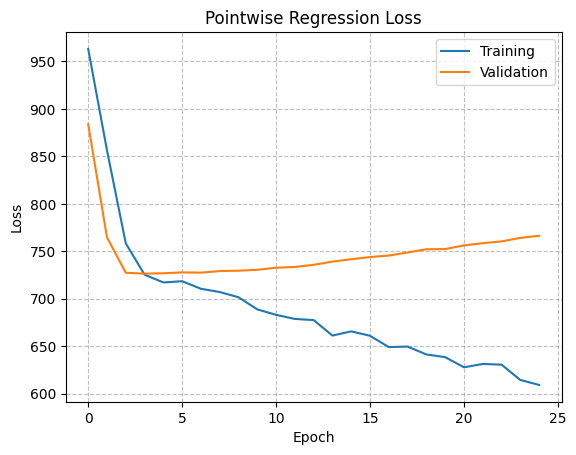

In [ ]:
plt.plot(pt_training_loss, label='Training')
plt.plot(pt_validation_loss, label='Validation')
plt.title('Pointwise Regression Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.show()

##Pairwise (Classification)
For every race, we take every combination of pairs of horses and predict which of the two will win. Although this is binary classification and logistic regression could be used, given the above model is regression, we wanted to try classification. Note for every pair of horses, we subtract their embeddings to keep the number of parameters low (rather than concatenating the embeddings).

###Data Preparation for Binary


In [ ]:
df = pd.read_csv("tf_idf_data.csv")
df = df.drop(df.columns[0], axis = 1)

# Initialize a defaultdict to store the results
results_dict = defaultdict(list)

# Get unique race IDs
race_ids = df['Race_Id'].unique()

# Iterate over race IDs
for race_id in race_ids:
    # Get the rows for the current race ID
    rows = df[df['Race_Id'] == race_id]

    # Iterate over all combinations of horse IDs in the current race
    for i, j in combinations(rows.index, 2):
        # Store the common information
        results_dict['Race_Id'].append(race_id)
        results_dict['Position_x'].append(rows.loc[i, 'Position'])
        results_dict['Position_y'].append(rows.loc[j, 'Position'])

        # Calculate the differences between the values for each column
        # Calculate the differences between the values for each column
        for col_name in [col for col in rows.columns if col not in ['horse_race_id', 'Position', 'Race_Id']]:
            col_diff = float(rows.loc[i, col_name]) - float(rows.loc[j, col_name])
            results_dict[col_name].append(col_diff)

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

def positions(x):
    if x['Position_x'] > x['Position_y']: #if horse 1 finishes later than horse 2
        return 0
    else:
        return 1

results_df['comparison'] = results_df[['Position_x', 'Position_y']].apply(positions, axis = 1)

df = results_df.drop(['Race_Id', 'Position_x', 'Position_y'], axis = 1)

In [ ]:
df.head()

,Horse Age,Horse Top Speed,Horse RPRS Ranking,Horse ORS Ranking,Horse Weight,Jockey Last 14,Trainer Last 14,0,1,2,...,91,92,93,94,95,96,97,98,99,comparison
0,0.00000,-0.147804,-0.218265,0.040272,0.067383,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.00000,-0.184755,-0.181887,0.080543,0.134914,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.44919,0.480362,0.145510,0.120815,0.202296,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.00000,-0.221706,-0.072755,0.201359,0.337359,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.44919,0.189400,-0.232839,0.402717,0.674718,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0


###Pairwise Model


In [ ]:
class Pairwise_Dataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]

        # Extract the input features and target
        features = torch.tensor(sample.drop('comparison').values, dtype=torch.float32)
        target = torch.tensor(sample['comparison'], dtype=torch.float32)

        return features, target.type(torch.LongTensor)

# Split the dataframe into train, validation, and test sets
pr_train_df, pr_test_df = train_test_split(df, test_size=0.2, random_state=42)
pr_train_df, pr_val_df = train_test_split(pr_train_df, test_size=0.2, random_state=42)

# Create the train, validation, and test datasets
pr_train_dataset = Pairwise_Dataset(pr_train_df)
pr_val_dataset = Pairwise_Dataset(pr_val_df)
pr_test_dataset = Pairwise_Dataset(pr_test_df)

batch_size = 32
pr_train_dataloader = DataLoader(pr_train_dataset, batch_size=batch_size, shuffle=True)
pr_val_dataloader = DataLoader(pr_val_dataset, batch_size=batch_size)
pr_test_dataloader = DataLoader(pr_test_dataset, batch_size=batch_size)

In [ ]:
class Pairwise(nn.Module):
    def __init__(self, embs_size, hidden_layer_size, dropout_prob):
        super(Pairwise, self).__init__()
        self.embs_size = embs_size
        self.linear1 = nn.Linear(embs_size, hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size, 2)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, X):
        out = self.linear1(X)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.dropout(out)
        return F.log_softmax(out, dim=1)

embs_size = 107
hidden_layer_size = 200
dropout_prob = 0.5

pairwise = Pairwise(embs_size, hidden_layer_size, dropout_prob)

In [ ]:
#training

num_epochs = 25
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(pairwise.parameters(), lr=learning_rate)

pr_training_loss = []
pr_training_accuracy = []
pr_validation_loss = []
pr_validation_accuracy = []

# Training loop
for epoch in range(num_epochs):
    pairwise.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(pr_train_dataloader, unit="batch") as tepoch:
            # Training the model
            for features, y_true in tepoch:

                optimizer.zero_grad()

                y_pred = pairwise(features)

                loss = loss_function(y_pred, y_true)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                total += y_true.size(0)
                y_label = torch.argmax(y_pred, axis =1)
                correct += torch.sum(y_label == y_true).item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(pr_train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    pr_training_loss.append(average_loss)

    tr_epoch_av = (100 * correct / total)
    print('Accuracy of epoch: %d %%' % tr_epoch_av)
    pr_training_accuracy.append(tr_epoch_av)

    # Validation loop
    pairwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for features, y_true in pr_val_dataloader:
            y_pred = pairwise(features)
            loss = loss_function(y_pred, y_true)
            val_loss += loss.item()

            val_total += y_true.size(0)
            y_label = torch.argmax(y_pred, axis =1)
            val_correct += torch.sum(y_label == y_true).item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(pr_val_dataloader)
    print(f"Validation Loss: {average_val_loss}")
    pr_validation_loss.append(average_val_loss)

    val_epoch_av = (100 * val_correct / val_total)
    print('Validation accuracy of epoch: %d %% \n' % val_epoch_av)
    pr_validation_accuracy.append(val_epoch_av)


# Testing loop
pairwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for features, y_true in pr_test_dataloader:
        y_pred = pairwise(features)
        loss = loss_function(y_pred, y_true)
        test_loss += loss.item()

        test_total += y_true.size(0)
        y_label = torch.argmax(y_pred, axis =1)
        test_correct += torch.sum(y_label == y_true).item()

# Print the average test loss
average_test_loss = test_loss / len(pr_test_dataloader)
print(f"Average Test Loss: {average_test_loss}")
print('Accuracy of epoch: %d %%' % (100 * test_correct / test_total))

100%|██████████| 258/258 [00:08<00:00, 29.73batch/s]


Epoch 1/25, Loss: 0.6781833442144616
Accuracy of epoch: 54 %
Validation Loss: 0.6600396037101746
Validation accuracy of epoch: 59 % 



100%|██████████| 258/258 [00:05<00:00, 48.59batch/s]


Epoch 2/25, Loss: 0.6608091696750286
Accuracy of epoch: 57 %
Validation Loss: 0.6558127018121572
Validation accuracy of epoch: 59 % 



100%|██████████| 258/258 [00:06<00:00, 40.45batch/s]


Epoch 3/25, Loss: 0.6505945685297944
Accuracy of epoch: 59 %
Validation Loss: 0.6500266414422256
Validation accuracy of epoch: 61 % 



100%|██████████| 258/258 [00:05<00:00, 48.34batch/s]


Epoch 4/25, Loss: 0.6430600567381511
Accuracy of epoch: 60 %
Validation Loss: 0.6478772108371441
Validation accuracy of epoch: 61 % 



100%|██████████| 258/258 [00:06<00:00, 40.82batch/s]


Epoch 5/25, Loss: 0.6342498064041138
Accuracy of epoch: 60 %
Validation Loss: 0.6471921471449045
Validation accuracy of epoch: 61 % 



100%|██████████| 258/258 [00:05<00:00, 49.10batch/s]


Epoch 6/25, Loss: 0.6279427808846614
Accuracy of epoch: 61 %
Validation Loss: 0.6440752011079055
Validation accuracy of epoch: 62 % 



100%|██████████| 258/258 [00:06<00:00, 40.26batch/s]


Epoch 7/25, Loss: 0.6233847838963649
Accuracy of epoch: 62 %
Validation Loss: 0.6438915353554946
Validation accuracy of epoch: 62 % 



100%|██████████| 258/258 [00:05<00:00, 48.09batch/s]


Epoch 8/25, Loss: 0.614395643620528
Accuracy of epoch: 63 %
Validation Loss: 0.6417782792678246
Validation accuracy of epoch: 62 % 



100%|██████████| 258/258 [00:06<00:00, 42.86batch/s]


Epoch 9/25, Loss: 0.6077761420214823
Accuracy of epoch: 62 %
Validation Loss: 0.6447782479799711
Validation accuracy of epoch: 61 % 



100%|██████████| 258/258 [00:05<00:00, 49.56batch/s]


Epoch 10/25, Loss: 0.6013420077488404
Accuracy of epoch: 64 %
Validation Loss: 0.6383572129102854
Validation accuracy of epoch: 63 % 



100%|██████████| 258/258 [00:05<00:00, 43.03batch/s]


Epoch 11/25, Loss: 0.5973607070686281
Accuracy of epoch: 64 %
Validation Loss: 0.6449294168215531
Validation accuracy of epoch: 62 % 



100%|██████████| 258/258 [00:05<00:00, 48.04batch/s]


Epoch 12/25, Loss: 0.5886265116837598
Accuracy of epoch: 65 %
Validation Loss: 0.6360420804757339
Validation accuracy of epoch: 63 % 



100%|██████████| 258/258 [00:05<00:00, 44.72batch/s]


Epoch 13/25, Loss: 0.580205878199533
Accuracy of epoch: 66 %
Validation Loss: 0.6393993643613962
Validation accuracy of epoch: 62 % 



100%|██████████| 258/258 [00:05<00:00, 46.47batch/s]


Epoch 14/25, Loss: 0.5719888852548229
Accuracy of epoch: 66 %
Validation Loss: 0.6400671436236455
Validation accuracy of epoch: 62 % 



100%|██████████| 258/258 [00:05<00:00, 46.21batch/s]


Epoch 15/25, Loss: 0.5691105495820674
Accuracy of epoch: 67 %
Validation Loss: 0.6366264829268822
Validation accuracy of epoch: 63 % 



100%|██████████| 258/258 [00:05<00:00, 45.13batch/s]


Epoch 16/25, Loss: 0.5602743019198262
Accuracy of epoch: 68 %
Validation Loss: 0.6428496938485365
Validation accuracy of epoch: 62 % 



100%|██████████| 258/258 [00:05<00:00, 47.78batch/s]


Epoch 17/25, Loss: 0.5599040752926538
Accuracy of epoch: 68 %
Validation Loss: 0.6397169755055354
Validation accuracy of epoch: 64 % 



100%|██████████| 258/258 [00:05<00:00, 43.71batch/s]


Epoch 18/25, Loss: 0.5524891052366228
Accuracy of epoch: 69 %
Validation Loss: 0.640842395562392
Validation accuracy of epoch: 63 % 



100%|██████████| 258/258 [00:05<00:00, 48.16batch/s]


Epoch 19/25, Loss: 0.544529731999072
Accuracy of epoch: 68 %
Validation Loss: 0.6377759823432335
Validation accuracy of epoch: 63 % 



100%|██████████| 258/258 [00:06<00:00, 42.75batch/s]


Epoch 20/25, Loss: 0.5436091520065485
Accuracy of epoch: 69 %
Validation Loss: 0.6382182836532593
Validation accuracy of epoch: 64 % 



100%|██████████| 258/258 [00:05<00:00, 47.94batch/s]


Epoch 21/25, Loss: 0.5309484672638797
Accuracy of epoch: 69 %
Validation Loss: 0.63800990489813
Validation accuracy of epoch: 64 % 



100%|██████████| 258/258 [00:06<00:00, 40.51batch/s]


Epoch 22/25, Loss: 0.5299222050018089
Accuracy of epoch: 70 %
Validation Loss: 0.638503844004411
Validation accuracy of epoch: 63 % 



100%|██████████| 258/258 [00:05<00:00, 48.05batch/s]


Epoch 23/25, Loss: 0.5259203514618467
Accuracy of epoch: 70 %
Validation Loss: 0.6430851459503174
Validation accuracy of epoch: 64 % 



100%|██████████| 258/258 [00:06<00:00, 39.25batch/s]


Epoch 24/25, Loss: 0.5162610381610634
Accuracy of epoch: 70 %
Validation Loss: 0.6410934218993554
Validation accuracy of epoch: 64 % 



100%|██████████| 258/258 [00:05<00:00, 46.93batch/s]


Epoch 25/25, Loss: 0.5073899505443351
Accuracy of epoch: 71 %
Validation Loss: 0.6459831022299253
Validation accuracy of epoch: 64 % 

Average Test Loss: 0.620752548362002
Accuracy of epoch: 66 %


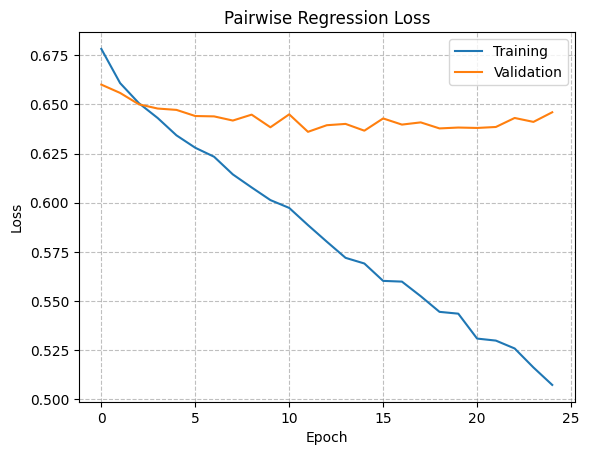

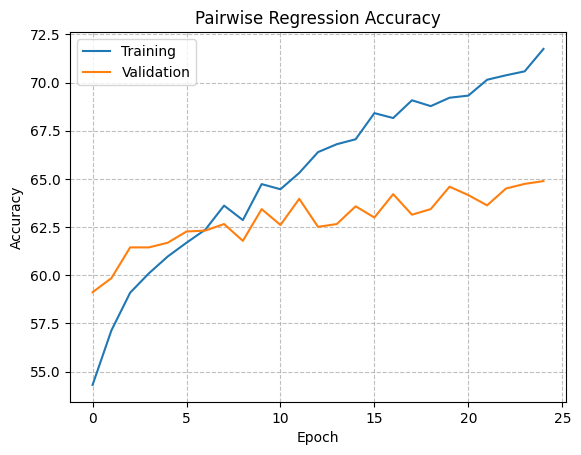

In [ ]:
# Plotting pairwise regression loss
plt.plot(pr_training_loss, label='Training')
plt.plot(pr_validation_loss, label='Validation')
plt.title('Pairwise Regression Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.show()

# Plotting pairwise regression accuracy
plt.plot(pr_training_accuracy, label='Training')
plt.plot(pr_validation_accuracy, label='Validation')
plt.title('Pairwise Regression Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.show()

##Listwise (Custom Loss Function - NDCG) (Attempt)

This is an attempt to use a listwise approach to predict the outcome of a race. Each race is represented by a 2d tensor where each row representes the tf_idf embedding for a horse. As different races have different numbers of horses, I've padded these 2d tensors to have the same number of rows as the max number of horses in a race in the batch, padding with rows of -1. To keep rows from the same race together when batching, I created a custom collate function. These 2d tensors are then fed into my NN which has a couple of fully connected layers with ReLU activation before being multiplied by a 1d tensor of size (emb_size, 1), this 1d tensor is a parameter of the network. This means the output for a race is a tensor of the length of number of horses in the max race for that batch. Note the actual output has more than 1 dimension as it contains the batch of races. I then created my own loss function to use ndcg. This function firstly uses the true rankings to find which indices have been padded and removes them from the predicted ranking. I then take the inverse of each of the true rankings and use sklearns ndcg_score function. nDCG favours higher values in a list, so taking the inverse means that the lower positions are favoured.

There are a few issues with what I've done. The main one is that the validation loss was not changing, literally the same number after every epoch, which was not right and suggested the parameters were None. After checking, this wasn't the case. I then tried shuffling the validation data and this led to changing values which was a little alarming. Any advice on this would be welcomed.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

df = pd.read_csv("tf_idf_data.csv")
df = df.drop(df.columns[0], axis = 1)
df = df.drop(columns = ['horse_race_id'], axis = 1)


#want all races together: create a list of tuples of (tensor of size n x 107, tensor of size n) where n is the number of horses in that race : i.e (all the race data, the positions)
grouped_data = df.groupby('Race_Id')

# Store the race tensors in a list
race_tensors = []

# Group the data by race_id and create separate feature and label tensors
for race_id, race_data in grouped_data:
    race_features = race_data.drop(columns=['Position', 'Race_Id']).apply(pd.to_numeric, errors='coerce').values.astype(float)  # Extract all columns except 'column_name'
    race_labels = race_data['Position'].apply(pd.to_numeric, errors='coerce').values.astype(float)  # Extract the 'column_name' as labels


    race_features_tensor = torch.tensor(race_features, dtype=torch.float32)
    race_labels_tensor = torch.tensor(race_labels, dtype=torch.float32)

    race_tensors.append((race_features_tensor, race_labels_tensor))

In [ ]:
print(race_tensors[0][0].shape, race_tensors[0][1].shape)

In [ ]:
#convert to datasets

features_list, labels_list = zip(*race_tensors)

# Perform train-test split
train_features, test_features, train_labels, test_labels = train_test_split(features_list, labels_list, test_size=0.2, random_state=42)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Convert the split data back to a list of tuples
ls_train_data = list(zip(train_features, train_labels))
ls_val_data = list(zip(val_features, val_labels))
ls_test_data = list(zip(test_features, test_labels))



# Define your custom dataset
class Listwise_Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

#Create a custom collate function to keep all horses of same race together

def race_collate(batch):
    # Separate the features and labels from the batch
    features_batch = [item[0] for item in batch]
    labels_batch = [item[1] for item in batch]

    # Pad the features and labels tensors so all same size, padding to max length
    padded_features_batch = pad_sequence(features_batch, batch_first=True, padding_value=-1)
    padded_labels_batch = pad_sequence(labels_batch, batch_first=True, padding_value=-1)

    return padded_features_batch, padded_labels_batch

# Assuming you have separate train_data, val_data, and test_data lists
ls_train_dataset = Listwise_Dataset(ls_train_data)
ls_val_dataset = Listwise_Dataset(ls_val_data)
ls_test_dataset = Listwise_Dataset(ls_test_data)

# Create DataLoader objects with the custom collate function
batch_size = 32
ls_train_dataloader = DataLoader(ls_train_dataset, batch_size=batch_size, collate_fn=race_collate, shuffle=True)
ls_val_dataloader = DataLoader(ls_val_dataset, batch_size=batch_size, collate_fn=race_collate, shuffle =True)
ls_test_dataloader = DataLoader(ls_test_dataset, batch_size=batch_size, collate_fn=race_collate)

In [ ]:
class Listwise(nn.Module):
    def __init__(self, emb_size):
        super(Listwise, self).__init__()
        # Define your model architecture here
        self.scorer = nn.Parameter(torch.randn(emb_size, 1))
        self.linear1 = nn.Linear(emb_size, emb_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        # calculate the scores
        result_tensor = torch.matmul(out, self.scorer)

        return result_tensor



In [ ]:
class NDCGLoss(nn.Module):
    def __init__(self, k):
        super(NDCGLoss, self).__init__()
        self.k = k

    def forward(self, y_true, y_pred):
        batch_size = y_true.size(0)  # Get the batch size

        all_ndcgs = []

        for i in range(batch_size):

            true_sample = y_true[i].squeeze().float()  # Remove the last dimension (size 1) from true tensor
            pred_sample = y_pred[i].squeeze().float()  # Remove the last dimension (size 1) from pred tensor

            mask_true = true_sample != -1
            true_sample = true_sample[mask_true]
            pred_sample = pred_sample[mask_true]

            true_sample = 1/true_sample

            # Convert continuous values to discrete relevance labels
            labels_pred = pred_sample.argsort(descending=True) + 1
            labels_true = true_sample.argsort(descending=True) + 1

            ndcg_individual = ndcg_score([labels_true.detach().cpu().numpy()], [labels_pred.detach().cpu().numpy()], k=self.k)
            all_ndcgs.append(ndcg_individual.item())

        # Compute the average NDCG for the batch
        average_ndcg = torch.tensor(all_ndcgs, requires_grad=True).mean()

        # Return the negative NDCG as the loss
        loss = 1 - average_ndcg
        return loss

In [ ]:
#training

num_epochs = 25
learning_rate = 0.01

embs_size = 107

listwise_ndcg_1 = Listwise(embs_size)

# Define the loss function and optimizer
loss_function = NDCGLoss(1)

optimizer = optim.Adam(listwise_ndcg_1.parameters(), lr=learning_rate)

ls_training_loss = []
ls_validation_loss = []

# Training loop
for epoch in range(num_epochs):
    listwise_ndcg_1.train()  # Set the model to training mode

    running_loss = 0.0

    with tqdm(ls_train_dataloader, unit="batch") as tepoch:
          # Training the model
          for features, y_true in tepoch:

              optimizer.zero_grad()

              y_pred = listwise_ndcg_1(features)

              y_true = y_true.unsqueeze(-1)

              loss = loss_function(y_true, y_pred)

              loss.backward()

              optimizer.step()

              running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(ls_train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    ls_training_loss.append(average_loss)

    # Validation loop
    listwise_ndcg_1.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for features, y_true in ls_val_dataloader:
            y_pred = listwise_ndcg_1(features)
            loss = loss_function(y_pred, y_true.unsqueeze(-1))
            val_loss += loss.item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(ls_val_dataloader)
    print(f"Validation Loss: {average_val_loss} \n")
    ls_validation_loss.append(average_val_loss)

# Testing loop
listwise_ndcg_1.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for features, y_true in ls_test_dataloader:
        y_pred = listwise_ndcg_1(features)
        loss = loss_function(y_pred, y_true.unsqueeze(-1))
        loss = loss.mean()
        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(ls_test_dataloader)
print(f"Average Test Loss: {average_test_loss}")

In [ ]:
plt.plot(ls_training_loss)
plt.plot(ls_validation_loss)
plt.show()

In [ ]:
#training

num_epochs = 25
learning_rate = 0.01

embs_size = 107

listwise_ndcg_2 = Listwise(embs_size)

# Define the loss function and optimizer
loss_function = NDCGLoss(2)

optimizer = optim.Adam(listwise_ndcg_2.parameters(), lr=learning_rate)

ls_training_loss = []
ls_validation_loss = []

# Training loop
for epoch in range(num_epochs):
    listwise_ndcg_2.train()  # Set the model to training mode

    running_loss = 0.0

    with tqdm(ls_train_dataloader, unit="batch") as tepoch:
          # Training the model
          for features, y_true in tepoch:

              optimizer.zero_grad()

              y_pred = listwise_ndcg_2(features)

              y_true = y_true.unsqueeze(-1)

              loss = loss_function(y_true, y_pred)

              loss.backward()

              optimizer.step()

              running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(ls_train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    ls_training_loss.append(average_loss)

    # Validation loop
    listwise_ndcg_2.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for features, y_true in ls_val_dataloader:
            y_pred = listwise_ndcg_2(features)
            loss = loss_function(y_pred, y_true.unsqueeze(-1))
            val_loss += loss.item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(ls_val_dataloader)
    print(f"Validation Loss: {average_val_loss} \n")
    ls_validation_loss.append(average_val_loss)

# Testing loop
listwise_ndcg_2.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for features, y_true in ls_test_dataloader:
        y_pred = listwise_ndcg_2(features)
        loss = loss_function(y_pred, y_true.unsqueeze(-1))
        loss = loss.mean()
        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(ls_test_dataloader)
print(f"Average Test Loss: {average_test_loss}")

In [ ]:
#training

num_epochs = 25
learning_rate = 0.01

embs_size = 107

listwise_ndcg_3 = Listwise(embs_size)

# Define the loss function and optimizer
loss_function = NDCGLoss(3)

optimizer = optim.Adam(listwise_ndcg_3.parameters(), lr=learning_rate)

ls_training_loss = []
ls_validation_loss = []

# Training loop
for epoch in range(num_epochs):
    listwise_ndcg_3.train()  # Set the model to training mode

    running_loss = 0.0

    with tqdm(ls_train_dataloader, unit="batch") as tepoch:
          # Training the model
          for features, y_true in tepoch:

              optimizer.zero_grad()

              y_pred = listwise_ndcg_3(features)

              y_true = y_true.unsqueeze(-1)

              loss = loss_function(y_true, y_pred)

              loss.backward()

              optimizer.step()

              running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(ls_train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    ls_training_loss.append(average_loss)

    # Validation loop
    listwise_ndcg_3.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for features, y_true in ls_val_dataloader:
            y_pred = listwise_ndcg_3(features)
            loss = loss_function(y_pred, y_true.unsqueeze(-1))
            val_loss += loss.item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(ls_val_dataloader)
    print(f"Validation Loss: {average_val_loss} \n")
    ls_validation_loss.append(average_val_loss)

# Testing loop
listwise_ndcg_3.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for features, y_true in ls_test_dataloader:
        y_pred = listwise_ndcg_3(features)
        loss = loss_function(y_pred, y_true.unsqueeze(-1))
        loss = loss.mean()
        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(ls_test_dataloader)
print(f"Average Test Loss: {average_test_loss}")

##CNN Regression

Using the same dataset as above (i.e each race embedded as a 2d tensor, with padding to max number of horses in the batch). Then as the max number of horses varies between batches, in order to have tensors of the same size, I did: for a 2d tensor, M of size n x emb_size where n is the number of horses in the race, the 2d tensor I fed into my NN was transpose(M) * M . So the resultant tensor had shape: emb_size x emb_size which is the same for all the batches. Note I also decided to pad these tensors with 0 which meant during the multiplication part, these entries would not have an influence on the resultant tensor. I then treated this problem as a CNN regression problem where the input is 1 channel, using a couple of convolutional layers increasing the channel size and using MaxPooling before flattenning into a couple fully connected layers with one output neuron. The loss function is MSE.

In [ ]:
df = pd.read_csv("tf_idf_data.csv")
df = df.drop(df.columns[0], axis = 1)
df = df.drop(columns = ['horse_race_id'], axis = 1)


#want all races together: create a list of tuples of (tensor of size n x 107, tensor of size n) where n is the number of horses in that race : i.e (all the race data, the positions)
grouped_data = df.groupby('Race_Id')

# Store the race tensors in a list
race_tensors = []

# Group the data by race_id and create separate feature and label tensors
for race_id, race_data in grouped_data:
    race_features = race_data.drop(columns=['Position', 'Race_Id']).apply(pd.to_numeric, errors='coerce').values.astype(float)  # Extract all columns except 'column_name'
    race_labels = race_data['Position'].apply(pd.to_numeric, errors='coerce').values.astype(float)  # Extract the 'column_name' as labels


    race_features_tensor = torch.tensor(race_features, dtype=torch.float32)
    race_labels_tensor = torch.argmin(torch.tensor(race_labels, dtype=torch.float32))

    race_tensors.append((race_features_tensor, race_labels_tensor))

In [ ]:
#convert to datasets

features_list, labels_list = zip(*race_tensors)

# Perform train-test split
train_features, test_features, train_labels, test_labels = train_test_split(features_list, labels_list, test_size=0.2, random_state=42)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Convert the split data back to a list of tuples
cnn_train_data = list(zip(train_features, train_labels))
cnn_val_data = list(zip(val_features, val_labels))
cnn_test_data = list(zip(test_features, test_labels))



# Define your custom dataset
class CNN_Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

#Create a custom collate function to keep all horses of same race together

def race_collate(batch):
    # Separate the features and labels from the batch
    features_batch = [item[0] for item in batch]
    labels_batch = [item[1] for item in batch]

    # Pad the features and labels tensors so all same size, padding to max length
    padded_features_batch = pad_sequence(features_batch, batch_first=True, padding_value= 0 )  #pad with 0 so when doing M.t * M these rows information is lost

    return padded_features_batch, torch.tensor(labels_batch)

# Assuming you have separate train_data, val_data, and test_data lists
cnn_train_dataset = CNN_Dataset(cnn_train_data)
cnn_val_dataset = CNN_Dataset(cnn_val_data)
cnn_test_dataset = CNN_Dataset(cnn_test_data)

# Create DataLoader objects with the custom collate function
batch_size = 32
cnn_train_dataloader = DataLoader(cnn_train_dataset, batch_size=batch_size, collate_fn=race_collate, shuffle=True)
cnn_val_dataloader = DataLoader(cnn_val_dataset, batch_size=batch_size, collate_fn=race_collate)
cnn_test_dataloader = DataLoader(cnn_test_dataset, batch_size=batch_size, collate_fn=race_collate)

In [ ]:
class CNN_Regression(nn.Module):
    def __init__(self, hidden_layer_size, dropout):
        super(CNN_Regression, self).__init__()
        #input size is 107x107 and padding = 0, and stride = 1
        self.conv1 = nn.Conv2d(1, 4, 5)  # output size = (107 - 5 + 2*0)/1 + 1 = 103
        self.pool1 = nn.MaxPool2d(2,2) #output size = 103/2 = 51  - take lower bound for divind by 2
        self.conv2 = nn.Conv2d(4, 6, 5) #output size = 51 - 5 + 1 = 47
        self.pool2 = nn.MaxPool2d(2,2) #output size = 47/2 = 23
        self.linear1 = nn.Linear(6*23*23, hidden_layer_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_layer_size, 1)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
      x = self.conv1(x)
      x = self.pool1(x)
      x = self.dropout(x)
      x = self.conv2(x)
      x = self.pool2(x)
      x = self.dropout(x)
      x = x.view(-1, 6*23*23) #flatten
      x = self.linear1(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.linear2(x)
      return x


hidden_layer_size = 200
dropout = 0.5

cnn_regression = CNN_Regression(hidden_layer_size, dropout)

In [ ]:
#training

num_epochs = 25
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(cnn_regression.parameters(), lr=learning_rate)

cnn_training_loss = []
cnn_val_loss = []

# Training loop
for epoch in range(num_epochs):
    cnn_regression.train()  # Set the model to training mode

    running_loss = 0.0


    with tqdm(cnn_train_dataloader, unit="batch") as tepoch:
            # Training the model
            for features, y_true in tepoch:

                features_transposed = features.transpose(1, 2)
                result = torch.matmul(features_transposed, features).unsqueeze(1)   # M.t * M to get matrices of size emb_seize x emb_size

                optimizer.zero_grad()
                y_pred = cnn_regression(result)
                y_true = y_true.to(torch.float)

                loss = loss_function(y_pred, y_true.view(-1, 1))
                loss = loss.to(torch.float)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()



    # Print the average loss for the epoch
    average_loss = running_loss / len(cnn_train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    cnn_training_loss.append(average_loss)

    # Validation loop
    pairwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for features, y_true in cnn_val_dataloader:

            features_transposed = features.transpose(1, 2)
            result = torch.matmul(features_transposed, features).unsqueeze(1)   # M.t * M to get matrices of size emb_seize x emb_size

            y_pred = cnn_regression(result)
            loss = loss_function(y_pred, y_true.view(-1, 1))
            val_loss += loss.item()



    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(cnn_val_dataloader)
    print(f"Validation Loss: {average_val_loss}")
    cnn_val_loss.append(average_val_loss)

# Testing loop
pairwise.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for features, y_true in cnn_test_dataloader:

        features_transposed = features.transpose(1, 2)
        result = torch.matmul(features_transposed, features).unsqueeze(1)   # M.t * M to get matrices of size emb_seize x emb_size


        y_pred = cnn_regression(result)
        loss = loss_function(y_pred, y_true.view(-1, 1))
        test_loss += loss.item()


# Print the average test loss
average_test_loss = test_loss / len(cnn_test_dataloader)
print(f"Average Test Loss: {average_test_loss}")


In [ ]:
plt.plot(cnn_training_loss)
plt.plot(cnn_val_loss)
plt.show()

#BERT


To obtain better results, we decided to use BERT to embed our predictions. We took the '[cls]' token and concatenated it with the numerical data to form an embedding for a horse.

In [ ]:
#since using BERT, switch to using GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))

## Pointwise (Regression)

In [ ]:
df = pd.read_csv("data.csv")
df = df.drop([df.columns[0], df.columns[9], df.columns[11]], axis = 1)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the column
normalized_column = scaler.fit_transform(df[['Position']])

# Update the column in the DataFrame
df['Position'] = normalized_column

#clean text data:

df['Prediction'] = df['Prediction'].apply(lambda x: x.lower())  #make all lowercase
df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','')   #remove punctuation

df.head()

In [ ]:
train_and_val_data, test_data = train_test_split( df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_and_val_data, test_size=0.2, random_state=42)

In [ ]:
word_count_train = train_and_val_data['Prediction'].apply(lambda x: len(x.split()))
word_count_test = test_data['Prediction'].apply(lambda x: len(x.split()))

In [ ]:
fig = plt.figure(figsize=[10,7])
sns.distplot(word_count_train, label = 'train', color=sns.xkcd_rgb['red'])
sns.distplot(word_count_test, label = 'test', color=sns.xkcd_rgb['blue'])
plt.legend()
plt.show()

In [ ]:
max_train_word_count = word_count_train.max()

In [ ]:
MAX_LEN_TRAIN = max_train_word_count
MAX_LEN_VALID = max_train_word_count
MAX_LEN_TEST = max_train_word_count

In [ ]:
class BERT_Pointwise_Dataset(Dataset):

    def __init__(self, data, maxlen, tokenizer):
        #Store the contents of the file in a pandas dataframe
        self.df = data.reset_index()
        #Initialize the tokenizer for the desired transformer model
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):

        # Extract the input features and target
        num_features = torch.tensor(self.df.drop(['index', 'Prediction', 'Position'], axis=1).iloc[index].values, dtype=torch.float32)

        #Select the sentence and label at the specified index in the data frame
        pred = self.df.loc[index, 'Prediction']
        try:
            position = self.df.loc[index, 'Position']
        except:
            position = -1.0

        #Preprocess the text to be suitable for the transformer
        tokens = self.tokenizer.tokenize(pred)
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]']
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = torch.tensor(input_ids)
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()

        position = torch.tensor(position, dtype=torch.float32)

        return num_features, input_ids, attention_mask, position

In [ ]:
BATCH_SIZE = 64
config = AutoConfig.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
## Training Dataset
train_set = BERT_Pointwise_Dataset(data=train_data, maxlen=MAX_LEN_TRAIN, tokenizer=tokenizer)
valid_set = BERT_Pointwise_Dataset(data=val_data, maxlen=MAX_LEN_VALID, tokenizer=tokenizer)
test_set = BERT_Pointwise_Dataset(data=test_data, maxlen=MAX_LEN_TEST, tokenizer=tokenizer)


## Data Loaders
bert_pointwise_train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE)
bert_pointwise_valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE)
bert_pointwise_test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE)

In [ ]:

class BERT_Pointwise(BertPreTrainedModel):
    def __init__(self, config, hidden_layer_size, freeze_bert=False, dropout = 0):
        super().__init__(config)
        self.bert = BertModel(config)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        #The output layer that takes the [CLS] representation and gives an output
        self.cls_linear1 = nn.Linear(config.hidden_size + 7, hidden_layer_size)   #note the +7 to add the numerical data on the end
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_layer_size,1)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)



    def forward(self, num_features, input_ids, attention_mask):
        #Feed the input to Bert model to obtain contextualized representations
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        logits = outputs.last_hidden_state[:,0,:]

        X = torch.cat((num_features, logits), -1).to(torch.float32)  #concatenate the numerical and textual data

        output = self.cls_linear1(X)
        output = self.relu1(output)
        output = self.dropout1(output)
        output = self.linear2(output)
        output = self.dropout2(output)
        return output

bert_pointwise = BERT_Pointwise(config, 200, freeze_bert = True, dropout = 0.5).to(device)


In [ ]:
#training

num_epochs = 10
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(bert_pointwise.parameters(), lr=learning_rate)

bert_pt_training_loss = []
bert_pt_val_loss = []


# Training loop
for epoch in range(num_epochs):
    bert_pointwise.train()  # Set the model to training mode

    running_loss = 0.0

    # Training the model
    with tqdm(bert_pointwise_train_loader, unit="batch") as tepoch:
          for num_features, input_ids, attention_mask, true_position in tepoch:

              num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

              optimizer.zero_grad()

              pred_position = bert_pointwise(num_features, input_ids, attention_mask)

              loss = loss_function(pred_position, true_position.unsqueeze(1))

              loss.backward()
              optimizer.step()

              running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(bert_pointwise_train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    bert_pt_training_loss.append(average_loss)

    # Validation loop
    bert_pointwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(bert_pointwise_valid_loader, unit="batch") as tepoch:

            for num_features, input_ids, attention_mask, true_position in tepoch:

                num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

                pred_position = bert_pointwise(num_features, input_ids, attention_mask)

                loss = loss_function(pred_position, true_position.unsqueeze(1))

                val_loss += loss.item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(bert_pointwise_valid_loader)
    print(f"Validation Loss: {average_val_loss} \n")
    bert_pt_val_loss.append(average_val_loss)

# Testing loop
bert_pointwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
  with tqdm(bert_pointwise_test_loader, unit="batch") as tepoch:
        for num_features, input_ids, attention_mask, true_position in tepoch:

                num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

                pred_position = bert_pointwise(num_features, input_ids, attention_mask)

                loss = loss_function(pred_position, true_position.unsqueeze(1))

                test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(bert_pointwise_test_loader)
print(f"Average Test Loss: {average_test_loss}")

In [ ]:
plt.plot(bert_pt_training_loss)
plt.plot(bert_pt_val_loss)
plt.show()

##Pairwise (Classification)

In [ ]:
df = pd.read_csv("data.csv")
df = df.drop([df.columns[0], df.columns[9]], axis = 1)

# Initialize a defaultdict to store the results
results_dict = defaultdict(list)

# Get unique race IDs
race_ids = df['Race_Id'].unique()

# Iterate over race IDs
for race_id in race_ids:
    # Get the rows for the current race ID
    rows = df[df['Race_Id'] == race_id]

    # Iterate over all combinations of horse IDs in the current race
    for i, j in combinations(rows.index, 2):
        # Store the common information
        results_dict['Race_Id'].append(race_id)
        results_dict['Position_x'].append(rows.loc[i, 'Position'])
        results_dict['Position_y'].append(rows.loc[j, 'Position'])
        results_dict['Prediction_x'].append(rows.loc[i, 'Prediction'])
        results_dict['Prediction_y'].append(rows.loc[j, 'Prediction'])


        # Calculate the differences between the values for each column
        # Calculate the differences between the values for each column
        for col_name in [col for col in rows.columns if col not in ['horse_race_id', 'Position', 'Race_Id', 'Prediction']]:
            col_diff = rows.loc[i, col_name] - rows.loc[j, col_name]
            results_dict[col_name].append(col_diff)

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

def positions(x):
    if x['Position_x'] > x['Position_y']: #if horse 1 finishes later than horse 2
        return 0
    else:
        return 1

results_df['comparison'] = results_df[['Position_x', 'Position_y']].apply(positions, axis = 1)

df = results_df.drop(['Race_Id', 'Position_x', 'Position_y'], axis = 1)

df.head()

In [ ]:
train_and_val_data, test_data = train_test_split( df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_and_val_data, test_size=0.2, random_state=42)

In [ ]:
class BERT_Pairwise_Dataset(Dataset):

    def __init__(self, data, maxlen, tokenizer):
        #Store the contents of the file in a pandas dataframe
        self.df = data.reset_index()
        #Initialize the tokenizer for the desired transformer model
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def process_text(self, pred_x, pred_y):
        #Preprocess the text to be suitable for the transformer
        tokens_x = self.tokenizer.tokenize(pred_x)
        tokens_y = self.tokenizer.tokenize(pred_y)
        tokens = ['[CLS]'] + tokens_x + ['[SEP]'] + tokens_y + ['[SEP]']
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]']
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = torch.tensor(input_ids)
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()

        return input_ids, attention_mask


    def __getitem__(self, index):

        # Extract the input features and target
        num_features = torch.tensor(self.df.drop(['index', 'Prediction_x', 'Prediction_y', 'comparison'], axis=1).iloc[index].values, dtype=torch.float32)

        try:
            comparison = self.df.loc[index, 'comparison']
        except:
            comparison = -1.0

        #Select the sentence and label at the specified index in the data frame
        pred_x = self.df.loc[index, 'Prediction_x']

        pred_y = self.df.loc[index, 'Prediction_y']

        inputs_ids, attention_mask = self.process_text(pred_x, pred_y)

        return num_features, inputs_ids, attention_mask, comparison

In [ ]:
BATCH_SIZE = 64
config = AutoConfig.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
## Training Dataset
train_set = BERT_Pairwise_Dataset(data=train_data, maxlen=2*MAX_LEN_TRAIN, tokenizer=tokenizer)    #Note the MAX_LEN_... is exactly the same as in Bert Pointwise as using same predictions
valid_set = BERT_Pairwise_Dataset(data=val_data, maxlen=2*MAX_LEN_VALID, tokenizer=tokenizer)
test_set = BERT_Pairwise_Dataset(data=test_data, maxlen=2*MAX_LEN_TEST, tokenizer=tokenizer)

## Data Loaders
bert_pairwise_train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE)
bert_pairwise_valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE)
bert_pairwise_test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE)

In [ ]:

class BERT_Pairwise(BertPreTrainedModel):
    def __init__(self, config, hidden_layer_size, freeze_bert=False, dropout = 0):
        super().__init__(config)
        self.bert = BertModel(config)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        #The output layer that takes the [CLS] representation and gives an output
        self.cls_linear1 = nn.Linear(config.hidden_size + 7, hidden_layer_size)   #note using BERT embedding then adding the 7 numerical features
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_layer_size,2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)



    def forward(self, num_features, inputs_ids, attention_mask):
        #For first prediction
        #Feed the input to Bert model to obtain contextualized representations
        outputs = self.bert(input_ids= inputs_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        logits = outputs.last_hidden_state[:,0,:]

        X = torch.cat((logits, num_features), -1).to(torch.float32)  #concatenate the numerical and textual data

        output = self.cls_linear1(X)
        output = self.relu1(output)
        output = self.dropout1(output)
        output = self.linear2(output)
        output = self.dropout2(output)
        return F.log_softmax(output, dim=1)



In [ ]:
#training
bert_pairwise_frozen = BERT_Pairwise(config, 200, freeze_bert = True, dropout = 0.5).to(device)

num_epochs = 10
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(bert_pairwise_frozen.parameters(), lr=learning_rate)

bert_pr_training_loss = []
bert_pr_val_loss = []
bert_pr_training_accuracy = []
bert_pr_val_accuracy = []
# Training loop
for epoch in range(num_epochs):
    bert_pairwise_frozen.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0
    print("Epoch: ", epoch)
    # Training the model
    with tqdm(bert_pairwise_train_loader, unit="batch") as tepoch:

          for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              optimizer.zero_grad()

              pred_comparison = bert_pairwise_frozen(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              correct += torch.sum(y_label == y_true).item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(bert_pairwise_train_loader)

    print(f"Loss for Epoch: {epoch + 1}/{num_epochs}, {average_loss}")
    bert_pr_training_loss.append(average_loss)

    print('Training accuracy of epoch: %d %% \n' % (100 * correct / total))
    bert_pr_training_accuracy.append((100 * correct / total))

    # Validation loop
    bert_pairwise_frozen.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
       with tqdm(bert_pairwise_valid_loader, unit="batch") as tepoch:
          for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              pred_comparison = bert_pairwise_frozen(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              val_loss += loss.item()

              val_total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              val_correct += torch.sum(y_label == y_true).item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(bert_pairwise_valid_loader)
    print(f"Validation Loss: {average_val_loss}")
    bert_pr_val_loss.append(average_val_loss)

    print('Validation accuracy of epoch: %d %% \n' % (100 * val_correct / val_total))
    bert_pr_val_accuracy.append((100 * val_correct / val_total))




# Testing loop
bert_pairwise_frozen.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
  with tqdm(bert_pairwise_test_loader, unit="batch") as tepoch:
      for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              pred_comparison = bert_pairwise_frozen(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              test_loss += loss.item()

              test_total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              test_correct += torch.sum(y_label == y_true).item()

# Print the average test loss
average_test_loss = test_loss / len(bert_pairwise_test_loader)
print(f"Average Test Loss: {average_test_loss}")
print('Validation accuracy of epoch: %d %% \n' % (100 * test_correct / test_total))


In [ ]:
plt.plot(bert_pr_training_loss)
plt.plot(bert_pr_val_loss)
plt.show()

plt.plot(bert_pr_training_accuracy)
plt.plot(bert_pr_val_accuracy)
plt.show()

In [ ]:
#training
bert_pairwise = BERT_Pairwise(config, 200, freeze_bert = False, dropout = 0.5).to(device)

num_epochs = 10
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(bert_pairwise.parameters(), lr=learning_rate)

bert_pr_training_loss = []
bert_pr_val_loss = []
bert_pr_training_accuracy = []
bert_pr_val_accuracy = []
# Training loop
for epoch in range(num_epochs):
    bert_pairwise.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0
    print("Epoch: ", epoch)
    # Training the model
    with tqdm(bert_pairwise_train_loader, unit="batch") as tepoch:

          for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              optimizer.zero_grad()

              pred_comparison = bert_pairwise(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              correct += torch.sum(y_label == y_true).item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(bert_pairwise_train_loader)

    print(f"Loss for Epoch: {epoch + 1}/{num_epochs}, {average_loss}")
    bert_pr_training_loss.append(average_loss)

    print('Training accuracy of epoch: %d %% \n' % (100 * correct / total))
    bert_pr_training_accuracy.append((100 * correct / total))

    # Validation loop
    bert_pointwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
       with tqdm(bert_pairwise_valid_loader, unit="batch") as tepoch:
          for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              pred_comparison = bert_pairwise(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              val_loss += loss.item()

              val_total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              val_correct += torch.sum(y_label == y_true).item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(bert_pairwise_valid_loader)
    print(f"Validation Loss: {average_val_loss}")
    bert_pr_val_loss.append(average_val_loss)

    print('Validation accuracy of epoch: %d %% \n' % (100 * val_correct / val_total))
    bert_pr_val_accuracy.append((100 * val_correct / val_total))




# Testing loop
bert_pairwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
  with tqdm(bert_pairwise_test_loader, unit="batch") as tepoch:
      for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              pred_comparison = bert_pairwise(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              test_loss += loss.item()

              test_total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              test_correct += torch.sum(y_label == y_true).item()

# Print the average test loss
average_test_loss = test_loss / len(bert_pairwise_test_loader)
print(f"Average Test Loss: {average_test_loss}")
print('Validation accuracy of epoch: %d %% \n' % (100 * test_correct / test_total))


# NDCG Evaluation


###Set File Names


In [ ]:
#The file that contains the predictions
file_names = [
    "bert_frozen_evaluation_pairwise.csv",
    "bert_frozen_evaluation_pointwise.csv",
    "bert_fine_tune_evaluation_pointwise.csv",
    "bert_fine_tuned_evaluation_pairwise.csv",
    "tf_idf_evaluation_pairwise.csv",
    "tf_idf_evaluation_pointwise.csv"
]


In [ ]:
#imports used
import pandas as pd
import numpy as np
import math
import statistics
import scipy

###Calculation Functions

####DCG function

In [ ]:
#Function used to calculate the discounted comulative gain, see report for formula and details
def dcg(posList, p_is_default, p):
    #p is the cutoff point for our ranking calculation. It can be altered to however many horses we want to take into
    #consideraton
    #Set p to default value
    if p_is_default:
      p = len(posList)
    #Otherwise p is the value set by the parameter p chosen by the user

    #Make sure there are at least p horses
    if len(posList)  >= p:
      sum = 0
      for i in range(0, p):
          rel_i = 1 / posList[i]
          curHorse = (pow(2, rel_i) - 1) / math.log2(i + 2)
          sum += curHorse
    #Used to not take into account races with less than p horses
    else:
      return -1

    return sum

####nDCG Function

In [ ]:
# Function used to calculate the normalised Discounted Cumulative Gain using the DCG formula above.
#nDCG = DCG / iDCG, see report for more details
def nDCG(fakePositions, realPositions,is_P_Default, p):
    # idcg is the best possible dcg value, used to normalise our dcg value. i for 'ideal'
    iDCG = dcg(sorted(realPositions, reverse=False),is_P_Default, p)
    # Invalid values
    if iDCG <= 0:
        return 0
    elif np.isnan(iDCG):
        return 0
    else:
        # Calculate DCG
        dcg_val = dcg(fakePositions, is_P_Default, p)
        # Normalise
        return dcg_val / iDCG

###Processing the CSV File

####Parsing Each Race

In [ ]:
#Function used to process csv file that contains data that contains the a set of races. Each row represents a race.
#For each race, the race can be identified by the race ID. There are then two lists, one contains an ordered list of the horses by their
#names as predicted by the model and the other a list of the results of the race with the names of the horse as an orderd list.
#The first row looks like this:
#,Race_id,Predictions,Results
#Takes a panda data frame of the csv file as a parameter and returns the average nDCG score across all races
def calculateNDCG(df,is_P_Default, p):
    ndcgs = []
    #Processing the date in order to calculate the NDCG scores.
    for row in df.iterrows():
        # basically was treating row as tuple
        fake = row[1]['Predictions'].replace("[", "").replace("]", "").replace('"', "").replace("'", "").strip().split(
            ",")  #strip stuff we dont want and split by comma
        true = row[1]['Results'].replace("[", "").replace("]", "").replace('"', "").replace("'", "").strip().split(",")

        for i in true:
            stripped = [j.strip() for j in i.split("_")]  # was some weird space between certain words before a _
            true[true.index(i)] = '_'.join(stripped)

        min_len = min(len(fake),
                      len(true))  # due to NR horses and other stuff, different lengths so taking to min length, as starting from index 0, only low ranked horses will be lost

        # only taking high positioned horses
        true_indices = []
        for i in true:
            if len(true_indices) < min_len:
                true_indices.append(len(true_indices) + 1)  # get indices for each horse

        fake_indices = []
        for i in fake:
            i = i.lstrip()  # was an odd whitespace at start of id so removed
            if (
                    len(fake_indices) < min_len) and i in true:  # sometimes the fake horse not in true horses (NR) so check that and make sure we dont get too high
                fake_indices.append(true.index(i) + 1)  # get index from true horses


        ndcgs.append(nDCG(fake_indices, true_indices, is_P_Default, p))

    return ndcgs

####Creating the Data Frame
 File and

In [ ]:
#Reads in all of the files and returns a dictionary: [fname : df]
def files_to_DF(file_names):
    dfs = {}
    for fname in file_names:
        df = pd.read_csv(fname)
        df = df.drop(df.columns[0], axis=1)
        dfs[fname] = df
    return dfs


dfs = files_to_DF(file_names)

####Calculating nDCG Scores

###Displaying Results of Evaluation


####TFIDF vs BERT

In [ ]:
ndcg_scores_default = {}  # Dictionary to store NDCG scores with default p
ndcg_scores_pSet = {}  # Dictionary to store NDCG scores with p set to 3

for fname, df in dfs.items():
    is_P_Default = True
    p = 0

    # Calculate NDCG scores without specifying p
    ndcg_scores_default[fname] = calculateNDCG(df, is_P_Default, p)

    is_P_Default = False
    p = 3

    # Calculate NDCG scores with p = 3
    ndcg_scores_pSet[fname] = calculateNDCG(df, is_P_Default, p)

####PointWise vs PairWise

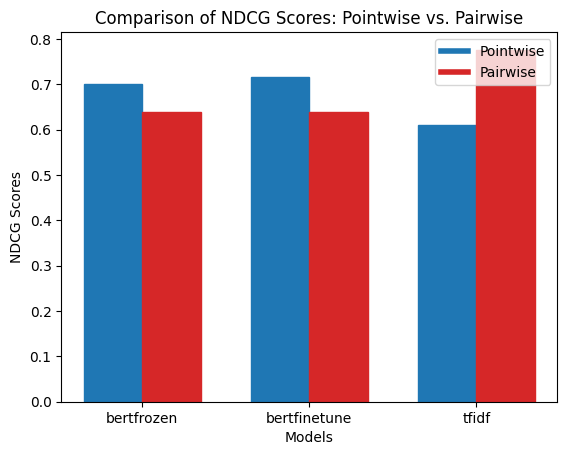

In [ ]:
# Prepare data for the bar chart
pointwise_scores = [statistics.mean(ndcg_scores_default[fname]) for fname in file_names if 'pointwise' in fname]
pairwise_scores = [statistics.mean(ndcg_scores_default[fname]) for fname in file_names if 'pairwise' in fname]

# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r = np.arange(len(pointwise_scores))

# Create the bar chart
fig, ax = plt.subplots()
pointwise_bars = ax.bar(r, pointwise_scores, width=bar_width, label='Pointwise')
pairwise_bars = ax.bar(r + bar_width, pairwise_scores, width=bar_width, label='Pairwise')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('NDCG Scores')
plt.title('Comparison of NDCG Scores: Pointwise vs. Pairwise')
plt.xticks(r + bar_width / 2, ('bertfrozen', 'bertfinetune', 'tfidf'))
plt.legend()

# Set colors for pointwise and pairwise bars
pointwise_bars[0].set_color('tab:blue')
pointwise_bars[1].set_color('tab:blue')
pointwise_bars[2].set_color('tab:blue')
pairwise_bars[0].set_color('tab:red')
pairwise_bars[1].set_color('tab:red')
pairwise_bars[2].set_color('tab:red')

# Create the legend for bar colors
pointwise_patch = plt.Line2D([0], [0], color='tab:blue', lw=4)
pairwise_patch = plt.Line2D([0], [0], color='tab:red', lw=4)
plt.legend([pointwise_patch, pairwise_patch], ['Pointwise', 'Pairwise'], loc='upper right')

# Show the graph
plt.show()

####P vs All Horses

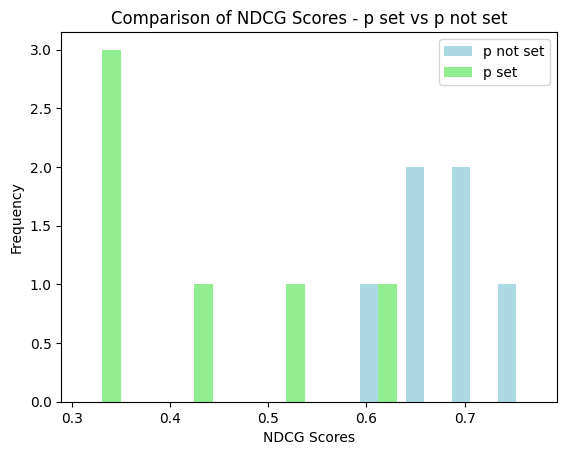

In [ ]:
# Prepare data for histogram
categories = ['p not set', 'p set']
scores_default = [statistics.mean(scores) for scores in ndcg_scores_default.values()]
scores_pSet = [statistics.mean(scores) for scores in ndcg_scores_pSet.values()]

# Set colors for bars
colors = ['lightblue', 'lightgreen']

# Plot the histogram
plt.hist([scores_default, scores_pSet], bins=10, color=colors, label=categories)

# Add labels and title
plt.xlabel('NDCG Scores')
plt.ylabel('Frequency')
plt.title('Comparison of NDCG Scores - p set vs p not set')

# Add legend
plt.legend()

# Show the histogram
plt.show()

#Statistical Analysis of Results

##T-test

In [ ]:
from scipy import stats

def ndcg_t_test(scores_a, scores_b):
    # Step 1: Calculate the differences
    differences = [a - b for a, b in zip(scores_a, scores_b)]

    # Step 2: Compute the mean difference
    mean_difference = sum(differences) / len(differences)

    # Step 3: Calculate the standard deviation of the differences
    standard_deviation = stats.tstd(differences)

    # Step 4: Perform the paired t-test
    t_value, p_value = stats.ttest_rel(scores_a, scores_b)

    # Step 5: Compare the calculated t-value with the critical t-value
    alpha = 0.05  # Significance level
    critical_t_value = stats.t.ppf(1 - alpha/2, len(differences) - 1)

    # Step 6: Interpret the results
    if t_value > critical_t_value:
        result = "There is a statistically significant difference."
    else:
        result = "There is no statistically significant difference."

    return result, p_value


#Results when p is default
result, p_value = ndcg_t_test(pointwise_scores, pairwise_scores)
print("T-test comparing the algorithms where p is default")
print(result)
print("p-value:", p_value)

#Results when p is set
print(f"T-test comparing the algorithms where p is set to {p}")
result, p_value = ndcg_t_test(pointwise_scores_pSet, pairwise_scores_pSet)
print(result)
print("p-value:", p_value)



T-test comparing the algorithms where p is default
There is no statistically significant difference.
p-value: 0.21125596077870668
T-test comparing the algorithms where p is set to 3
There is no statistically significant difference.
p-value: 0.13720569318939446


#Test Data Processing

In [ ]:
df_pred_test = pd.read_csv("preds_test.csv")

FileNotFoundError: ignored

In [ ]:
#for tf_idf: prepare the data

# clean the data

def clean_preds(df_preds):

      df_preds['Race Location'] = df_preds['Race Location'].str.replace(r'\(.*?\)', '', regex=True)

      df_preds = df_preds[df_preds['Date'] != 'Date']  #deleting rows with the column titles
      df_preds = df_preds.reset_index()
      df_preds = df_preds.drop("index", axis = 1)  #dropping index columns
      df_preds = df_preds.replace('[\'NaN\']', np.nan)

      #just want horse-race id and the predictions
      df_preds['race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"] #create race id
      df_preds['horse_race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"]+ "_" + df_preds["Horse Name"] #create horse id
      df_preds = df_preds.drop(["Date", "Time", "Race Location", "Going", "Horse Name"], axis = 1) #drop all data now stored in horse id
      df_preds = df_preds.drop_duplicates()
      df_preds.Prediction = df_preds.Prediction.astype(str)
      df_preds.horse_race_id = df_preds.horse_race_id.astype(str)
      df_preds = df_preds.replace('-', np.nan)

      for i in df_preds.columns[df_preds.isnull().any(axis=0)]:     # replace nan with the mean of a column
          df_preds[i].fillna(pd.to_numeric(df_preds[i]).mean(),inplace=True)


      cols_to_norm = ['Horse Age', 'Horse Top Speed', 'Horse RPRS Ranking', 'Horse ORS Ranking', 'Horse Weight', 'Jockey Last 14', 'Trainer Last 14']

      normalized_df_preds = df_preds[cols_to_norm].astype(float)  #standardize the data
      normalized_df_preds = (normalized_df_preds-normalized_df_preds.mean())/normalized_df_preds.std()


      df_preds[cols_to_norm] = normalized_df_preds
      df_preds['Prediction'] = df_preds['Prediction'].apply(lambda x: x.lower())  #make all lowercase
      df_preds["Prediction"] = df_preds['Prediction'].str.replace('[^\w\s]','')
      df_preds['race_id'] = df_preds['race_id'].apply(lambda x: x.strip())
      return df_preds

df_pred_test = clean_preds(df_pred_test)
df_pred_test.head()

In [ ]:
df_res_test = pd.read_csv("results_test.csv")

In [ ]:

def clean_res(df_res):
    df_res['Race Location'] = df_res['Race Location'].str.replace(r'\(.*?\)', '', regex=True)

    df_res = df_res[df_res['Date'] != 'Date']
    df_res = df_res.drop_duplicates()
    df_res = df_res.reset_index()
    df_res = df_res.drop("index", axis = 1)
    df_res['race_id'] = df_res['Date']+ "_" + df_res['Time'] + "_" + df_res["Race Location"]
    df_res['horse_race_id'] = df_res['Date']+ "_" + df_res['Time'] + "_" + df_res["Race Location"]+ "_" + df_res["Horse Name"]
    df_res = df_res[["race_id", "horse_race_id", "Position"]]

    def get_type(x):  #sometimes position is text ie NR for the horse being a Non_Runne, want to penalise this so give a high score
        try:
            return float(x)
        except:
            return 100


    df_res['Position'] = df_res['Position'].apply(get_type) #apply the above function to Position values
    df_res.reset_index(inplace = True)
    df_res = df_res.drop(["index"], axis = 1)
    df_res.horse_race_id = df_res.horse_race_id.astype(str)
    df_res['race_id'] = df_res['race_id'].apply(lambda x: x.strip())
    return df_res

df_res_test = clean_res(df_res_test)

In [ ]:
grouped = df_res_test.groupby('race_id')

results = pd.DataFrame(columns=['Race_id', 'Predictions'])



for name, group in grouped:
    h_pos = []

    for i, j in enumerate(group['Position'].values):
        h_name = group['horse_race_id'].iloc[i]
        h_pos.append((h_name, j))

    sorted_scores = sorted(h_pos, key = lambda x: x[1])  #although already in order, sort just to make sure

    horse_ranks = [i[0] for i in sorted_scores]

    df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_ranks]})
    results = pd.concat([results, df])

results.head()



##TF_IDF


In [ ]:
def add_tf_idf(df, n):
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the "Prediction" column
    tfidf_separate = tfidf_vectorizer.fit_transform(df["Prediction"])

    # Get the vocabulary and its corresponding indices
    vocab = tfidf_vectorizer.vocabulary_
    vocab_indices = tfidf_vectorizer.get_feature_names_out()

    # Sum the tf-idf values for each word for each document (i.e., summing the columns of the tfidf_separate matrix above)
    combined_tfidf = tfidf_separate.toarray().sum(axis=0)

    # Sort the combined_tfidf values in descending order and take the first n indices
    indices_n_highest = combined_tfidf.argsort()[::-1][:n]

    # Get the words corresponding to the highest tf-idf values
    words_n_highest = [vocab_indices[i] for i in indices_n_highest]

    #perform BOW using the highest tfidf words as our set of words
    bow_counter = CountVectorizer()
    bow_counter.fit(words_n_highest)
    bow_applied = bow_counter.transform(df['Prediction'])

    #add these new values to the dataframe
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(bow_applied.toarray()).reset_index(drop=True)], axis=1)
    return(df)

#add this new data, can go higher than 100
df_pred_test = add_tf_idf(df_pred_test, 100)

#drop the prediction sentences
df_pred_test = df_pred_test.drop('Prediction', axis = 1)


###Pointwise

In [ ]:
grouped = df_pred_test.groupby('race_id')

pt_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  data = group.drop(['horse_race_id', 'race_id'], axis =1)
  torch_tensor = torch.tensor(data.values)
  pred_scores = pointwise(torch_tensor.to(torch.float32))
  indices = torch.argsort(pred_scores, dim = 0, descending = False)
  horse_names = []
  for i in indices:
    h_name = group['horse_race_id'].iloc[i.item()]
    horse_names.append(h_name)

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_names]})
  pt_preds = pd.concat([pt_preds, df])

pt_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(pt_preds, results, on='Race_id', how = 'inner')

pred_test_df.head()

###Pairwise

In [ ]:
#prep data for pairwise

# Initialize a defaultdict to store the results
pr_test = defaultdict(list)

# Get unique race IDs
race_ids = df_pred_test['race_id'].unique()

# Iterate over race IDs
for race_id in race_ids:
    # Get the rows for the current race ID
    rows = df_pred_test[df_pred_test['race_id'] == race_id]

    # Iterate over all combinations of horse IDs in the current race
    for i, j in combinations(rows.index, 2):
        # Store the common information
        pr_test['Race_Id'].append(race_id)
        pr_test['Horse_Id_x'].append(rows.loc[i, 'horse_race_id'])
        pr_test['Horse_Id_y'].append(rows.loc[j, 'horse_race_id'])

        # Calculate the differences between the values for each column
        # Calculate the differences between the values for each column
        for col_name in [col for col in rows.columns if col not in ['horse_race_id', 'race_id']]:
            col_diff = float(rows.loc[i, col_name]) - float(rows.loc[j, col_name])
            pr_test[col_name].append(col_diff)

# Create a DataFrame from the dictionary
pr_test = pd.DataFrame(pr_test)
pr_test.head()

In [ ]:
grouped = pr_test.groupby('Race_Id')

pr_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:
  df_horses = {}

  for i in group['Horse_Id_x'].values:
    if i not in df_horses:
      df_horses[i] = 0

  for i in group['Horse_Id_y'].values:
    if i not in df_horses:
      df_horses[i] = 0

  data = group.drop(['Horse_Id_x', 'Horse_Id_y', 'Race_Id'], axis =1)
  torch_tensor = torch.tensor(data.values)
  pred_scores = pairwise(torch_tensor.to(torch.float32))

  for i, j in enumerate(pred_scores):
    h_1_name = group['Horse_Id_x'].iloc[i]
    h_2_name = group['Horse_Id_y'].iloc[i]

    df_horses[h_1_name] += j[0].item()
    df_horses[h_2_name] += j[1].item()

  horse_scores = []

  for i in df_horses.keys():
    horse_scores.append((i, df_horses[i]))

  sorted_scores = sorted(horse_scores, key = lambda x: x[1], reverse = False)

  horse_ranks = [i[0] for i in sorted_scores]

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_ranks]})
  pr_preds = pd.concat([pr_preds, df])



pr_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(pr_preds, results, on='Race_id', how = 'inner')

pred_test_df.head()

###Listwise

In [ ]:
grouped = df_pred_test.groupby('race_id')

ls_ndcg_1_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  data = group.drop(['horse_race_id', 'race_id'], axis =1)
  torch_tensor = torch.tensor(data.values)
  pred_scores = listwise_ndcg_1(torch_tensor.to(torch.float32))
  indices = torch.argsort(pred_scores, dim = 0, descending = False)

  horse_names = []

  for i in indices:
    if i.item() < group.shape[0]:
      h_name = group['horse_race_id'].iloc[i.item()]
      horse_names.append(h_name)

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_names]})
  ls_ndcg_1_preds = pd.concat([ls_ndcg_1_preds, df])

ls_ndcg_1_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(ls_ndcg_1_preds, results, on='Race_id', how = 'inner')

pred_test_df.head()

In [ ]:
grouped = df_pred_test.groupby('race_id')

ls_ndcg_2_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  data = group.drop(['horse_race_id', 'race_id'], axis =1)
  torch_tensor = torch.tensor(data.values)
  pred_scores = listwise_ndcg_2(torch_tensor.to(torch.float32))
  indices = torch.argsort(pred_scores, dim = 0, descending = False)

  horse_names = []

  for i in indices:
    if i.item() < group.shape[0]:
      h_name = group['horse_race_id'].iloc[i.item()]
      horse_names.append(h_name)

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_names]})
  ls_ndcg_2_preds = pd.concat([ls_ndcg_2_preds, df])

ls_ndcg_2_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(ls_ndcg_2_preds, results, on='Race_id', how = 'inner')

pred_test_df.head()

In [ ]:
grouped = df_pred_test.groupby('race_id')

ls_ndcg_3_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  data = group.drop(['horse_race_id', 'race_id'], axis =1)
  torch_tensor = torch.tensor(data.values)
  pred_scores = listwise_ndcg_3(torch_tensor.to(torch.float32))
  indices = torch.argsort(pred_scores, dim = 0, descending = True)

  horse_names = []

  for i in indices:
    if i.item() < group.shape[0]:
      h_name = group['horse_race_id'].iloc[i.item()]
      horse_names.append(h_name)

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_names]})
  ls_ndcg_3_preds = pd.concat([ls_ndcg_3_preds, df])

ls_ndcg_3_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(ls_ndcg_3_preds, results, on='Race_id', how = 'inner')

pred_test_df.head()

###CNN

In [ ]:
grouped = df_pred_test.groupby('race_id')

cnn_df = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  data = group.drop(['horse_race_id', 'race_id'], axis =1)
  torch_tensor = torch.tensor(data.values).to(torch.float32)
  data_transposed = torch.transpose(torch_tensor, 0, 1)

  result = torch.matmul(data_transposed, torch_tensor).unsqueeze(0)   # M.t * M to get matrices of size emb_seize x emb_size
  pred_scores = cnn_regression(result)

  index = round(pred_scores.item())
  if index < group.shape[0]:
    h_name = group['horse_race_id'].iloc[index]
  else:
    h_name = group['horse_race_id'].iloc[group.shape[0]]


  df = pd.DataFrame({'Race_id': name, 'Predictions': [h_name]})
  cnn_df = pd.concat([cnn_df, df])

cnn_df.head()


In [ ]:
#merge
pred_test_df = pd.merge(cnn_df, results, on='Race_id', how = 'inner')

pred_test_df['Predictions_y'] = pred_test_df['Predictions_y'].apply(lambda x: x[0])

pred_test_df.head()

##BERT

In [ ]:
df_pred_test = pd.read_csv("preds_test.csv")
#for tf_idf: prepare the data

# clean the data

def clean_preds(df_preds):

      df_preds['Race Location'] = df_preds['Race Location'].str.replace(r'\(.*?\)', '', regex=True)

      df_preds = df_preds[df_preds['Date'] != 'Date']  #deleting rows with the column titles
      df_preds = df_preds.reset_index()
      df_preds = df_preds.drop("index", axis = 1)  #dropping index columns
      df_preds = df_preds.replace('[\'NaN\']', np.nan)

      #just want horse-race id and the predictions
      df_preds['race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"] #create race id
      df_preds['horse_race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"]+ "_" + df_preds["Horse Name"] #create horse id
      df_preds = df_preds.drop(["Date", "Time", "Race Location", "Going", "Horse Name"], axis = 1) #drop all data now stored in horse id
      df_preds = df_preds.drop_duplicates()
      df_preds.Prediction = df_preds.Prediction.astype(str)
      df_preds.horse_race_id = df_preds.horse_race_id.astype(str)
      df_preds = df_preds.replace('-', np.nan)

      for i in df_preds.columns[df_preds.isnull().any(axis=0)]:     # replace nan with the mean of a column
          df_preds[i].fillna(pd.to_numeric(df_preds[i]).mean(),inplace=True)


      cols_to_norm = ['Horse Age', 'Horse Top Speed', 'Horse RPRS Ranking', 'Horse ORS Ranking', 'Horse Weight', 'Jockey Last 14', 'Trainer Last 14']

      normalized_df_preds = df_preds[cols_to_norm].astype(float)  #standardize the data
      normalized_df_preds = (normalized_df_preds-normalized_df_preds.mean())/normalized_df_preds.std()


      df_preds[cols_to_norm] = normalized_df_preds
      df_preds['Prediction'] = df_preds['Prediction'].apply(lambda x: x.lower())  #make all lowercase
      df_preds["Prediction"] = df_preds['Prediction'].str.replace('[^\w\s]','')
      df_preds['race_id'] = df_preds['race_id'].apply(lambda x: x.strip())
      return df_preds

df_pred_test = clean_preds(df_pred_test)
df_pred_test.head()

###Pointwise

In [ ]:
# Extract the input features and target
num_features = torch.tensor(self.df.drop(['index', 'Prediction', 'Position'], axis=1).iloc[index].values, dtype=torch.float32)

#Select the sentence and label at the specified index in the data frame
pred = self.df.loc[index, 'Prediction']
try:
    position = self.df.loc[index, 'Position']
except:
    position = -1.0

#Preprocess the text to be suitable for the transformer
tokens = self.tokenizer.tokenize(pred)
tokens = ['[CLS]'] + tokens + ['[SEP]']
if len(tokens) < self.maxlen:
    tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]
else:
    tokens = tokens[:self.maxlen-1] + ['[SEP]']
#Obtain the indices of the tokens in the BERT Vocabulary
input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(input_ids)
#Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
attention_mask = (input_ids != 0).long()

In [ ]:
grouped = df_pred_test.groupby('race_id')

bert_pt_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  num_features = torch.tensor(group.drop(['Prediction', 'race_id', 'horse_race_id'], axis=1).values, dtype=torch.float32)
  pred = group['Prediction'].values

  word_count = group['Prediction'].apply(lambda x: len(x.split()))
  max_word_count = word_count.max()

  ids_msk_per_horse = []

  tokens = tokenizer.tokenize(pred)
  tokens = ['[CLS]'] + tokens + ['[SEP]']

  if len(tokens) < max_word_count:
      tokens = tokens + ['[PAD]' for _ in range(max_word_count - len(tokens))]
  else:
      tokens = tokens[:max_word_count-1] + ['[SEP]']
  #Obtain the indices of the tokens in the BERT Vocabulary
  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_ids = torch.tensor(input_ids)
  #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
  attention_mask = (input_ids != 0).long()


  print(num_features.shape)
  print(bert_pointwise(num_features, input_ids, attention_mask))

#bert_pt_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(bert_pt_preds, results, on='Race_id', how = 'inner')

pred_test_df.head()